## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp033'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 8 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 3 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.PiecewiseAffine(p=0.3), #IAAPiecewiseAffine
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([8, 224, 224])

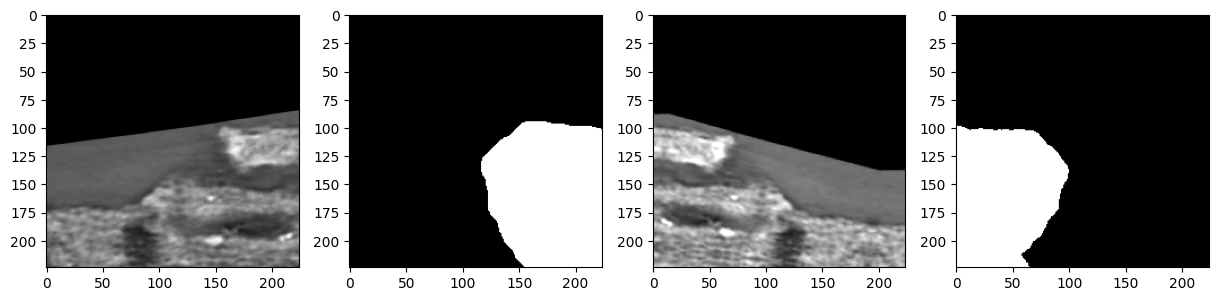

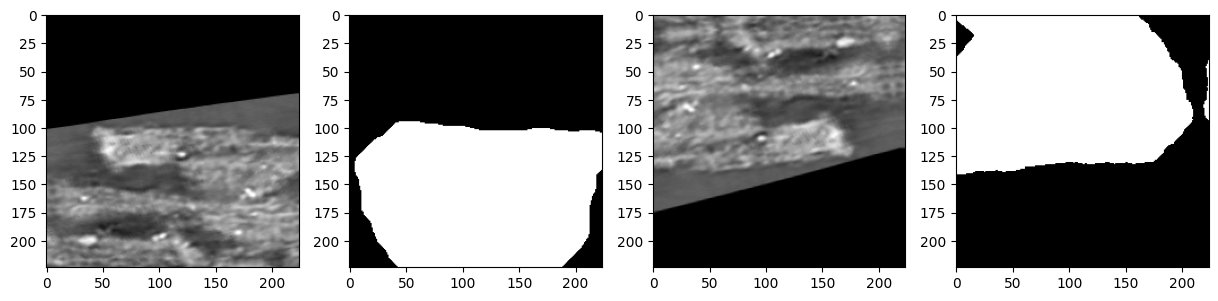

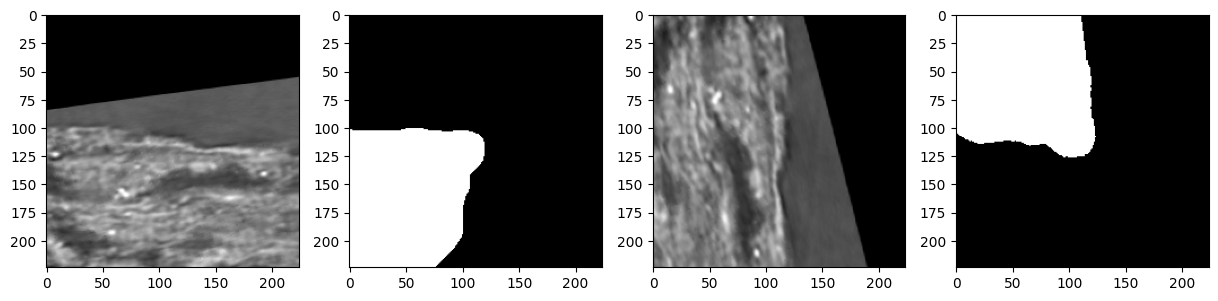

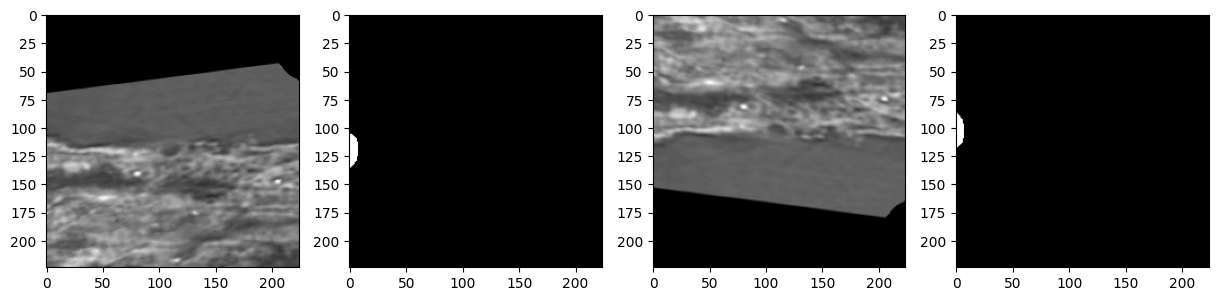

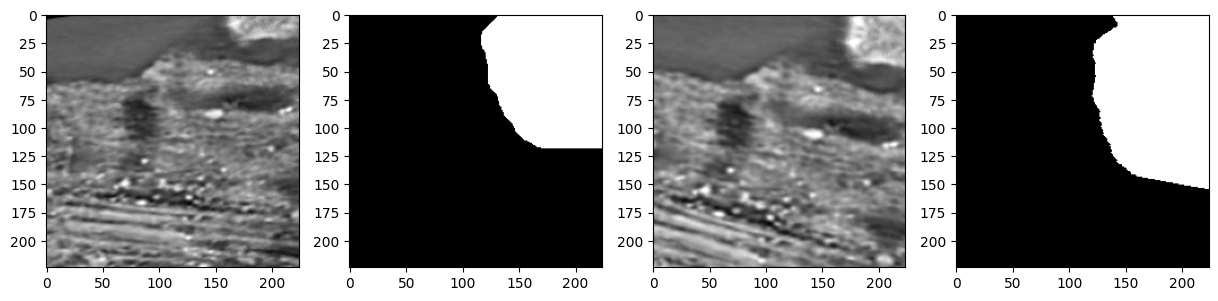

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

53880

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/966 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.09501641067128576
th: 0.15, fbeta: 0.09506193109666568
th: 0.2, fbeta: 0.1361897854555915
th: 0.25, fbeta: 0.1630448350480931
th: 0.3, fbeta: 0.21676975429901718
th: 0.35, fbeta: 0.2890407294560929
th: 0.4, fbeta: 0.34264911313430924


best_th: 0.5, fbeta: 0.371868773801631
Epoch 1 - avg_train_loss: 0.5656  avg_val_loss: 0.3740  time: 161s
Epoch 1 - avgScore: 0.3719
Epoch 1 - Save Best Score: 0.3719 Model
Epoch 1 - Save Best Loss: 0.3740 Model


th: 0.45, fbeta: 0.36818806362825046
th: 0.5, fbeta: 0.371868773801631


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.09503751962054527
th: 0.15, fbeta: 0.14945885186376892
th: 0.2, fbeta: 0.20896668988290093
th: 0.25, fbeta: 0.32622920591765975
th: 0.3, fbeta: 0.37351718340498524
th: 0.35, fbeta: 0.4053027603539963
th: 0.4, fbeta: 0.4245354566530562
th: 0.45, fbeta: 0.436020998270343


best_th: 0.5, fbeta: 0.439709821657485
Epoch 2 - avg_train_loss: 0.3790  avg_val_loss: 0.2909  time: 164s
Epoch 2 - avgScore: 0.4397
Epoch 2 - Save Best Score: 0.4397 Model
Epoch 2 - Save Best Loss: 0.2909 Model


th: 0.5, fbeta: 0.439709821657485


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:728: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


th: 0.1, fbeta: 0.2206598423524233
th: 0.15, fbeta: 0.28415804561927427
th: 0.2, fbeta: 0.33803281237856264
th: 0.25, fbeta: 0.3876240194353612
th: 0.3, fbeta: 0.4254223923306111
th: 0.35, fbeta: 0.45202587199588184
th: 0.4, fbeta: 0.4726287239858683
th: 0.45, fbeta: 0.4856321218562877


best_th: 0.5, fbeta: 0.49361873242025844
Epoch 3 - avg_train_loss: 0.2901  avg_val_loss: 0.2085  time: 163s
Epoch 3 - avgScore: 0.4936
Epoch 3 - Save Best Score: 0.4936 Model
Epoch 3 - Save Best Loss: 0.2085 Model


th: 0.5, fbeta: 0.49361873242025844


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2085131449120915
th: 0.15, fbeta: 0.23370216885377765
th: 0.2, fbeta: 0.25109928866022263
th: 0.25, fbeta: 0.26622130517122894
th: 0.3, fbeta: 0.28106223495571897
th: 0.35, fbeta: 0.29601512171220706
th: 0.4, fbeta: 0.31210096737437254
th: 0.45, fbeta: 0.3272401063961335


best_th: 0.5, fbeta: 0.3421277999407076
Epoch 4 - avg_train_loss: 0.2525  avg_val_loss: 0.2822  time: 163s
Epoch 4 - avgScore: 0.3421


th: 0.5, fbeta: 0.3421277999407076


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2991012616770015
th: 0.15, fbeta: 0.34217189623690525
th: 0.2, fbeta: 0.38099921224782135
th: 0.25, fbeta: 0.417018998753221
th: 0.3, fbeta: 0.4522175374487147
th: 0.35, fbeta: 0.48525478721086673
th: 0.4, fbeta: 0.5173947930475074
th: 0.45, fbeta: 0.5501067861136716


best_th: 0.5, fbeta: 0.5807571869987851
Epoch 5 - avg_train_loss: 0.2376  avg_val_loss: 0.1837  time: 161s
Epoch 5 - avgScore: 0.5808
Epoch 5 - Save Best Score: 0.5808 Model
Epoch 5 - Save Best Loss: 0.1837 Model


th: 0.5, fbeta: 0.5807571869987851


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2765964780796994
th: 0.15, fbeta: 0.33616669530661936
th: 0.2, fbeta: 0.3951581353292168
th: 0.25, fbeta: 0.4567189751481968
th: 0.3, fbeta: 0.5145392599978517
th: 0.35, fbeta: 0.5577326514840143
th: 0.4, fbeta: 0.5841564859402224
th: 0.45, fbeta: 0.5960630187017049


best_th: 0.45, fbeta: 0.5960630187017049
Epoch 6 - avg_train_loss: 0.2254  avg_val_loss: 0.1900  time: 162s
Epoch 6 - avgScore: 0.5961
Epoch 6 - Save Best Score: 0.5961 Model
Epoch 6 - Save Best Loss: 0.1900 Model


th: 0.5, fbeta: 0.5956551931235138


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.361075603240589
th: 0.15, fbeta: 0.41580420720172573
th: 0.2, fbeta: 0.45880466859686797
th: 0.25, fbeta: 0.494347412898541
th: 0.3, fbeta: 0.5250298131731107
th: 0.35, fbeta: 0.5479995432659314
th: 0.4, fbeta: 0.5642371341424782
th: 0.45, fbeta: 0.5758818190862516


best_th: 0.5, fbeta: 0.5820604794304548
Epoch 7 - avg_train_loss: 0.2123  avg_val_loss: 0.1941  time: 163s
Epoch 7 - avgScore: 0.5821


th: 0.5, fbeta: 0.5820604794304548


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29227155589399967
th: 0.15, fbeta: 0.3311233646931213
th: 0.2, fbeta: 0.3622073769971567
th: 0.25, fbeta: 0.3884573536922414
th: 0.3, fbeta: 0.4121504940494328
th: 0.35, fbeta: 0.4355034958903509
th: 0.4, fbeta: 0.45702372771613303
th: 0.45, fbeta: 0.47703841671751


best_th: 0.5, fbeta: 0.49571153154905373
Epoch 8 - avg_train_loss: 0.2009  avg_val_loss: 0.2244  time: 164s
Epoch 8 - avgScore: 0.4957


th: 0.5, fbeta: 0.49571153154905373


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2786082417095347
th: 0.15, fbeta: 0.3163388999524077
th: 0.2, fbeta: 0.34711772453630624
th: 0.25, fbeta: 0.37557137081859215
th: 0.3, fbeta: 0.40006601310878553
th: 0.35, fbeta: 0.41977882469193717
th: 0.4, fbeta: 0.4389585492043519
th: 0.45, fbeta: 0.460745499925588


best_th: 0.5, fbeta: 0.4830229152196668
Epoch 9 - avg_train_loss: 0.1902  avg_val_loss: 0.2257  time: 163s
Epoch 9 - avgScore: 0.4830


th: 0.5, fbeta: 0.4830229152196668


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4021258348500865
th: 0.15, fbeta: 0.4396712909105807
th: 0.2, fbeta: 0.4706698294771204
th: 0.25, fbeta: 0.4976511178084739
th: 0.3, fbeta: 0.5203267278029453
th: 0.35, fbeta: 0.5358020691351543
th: 0.4, fbeta: 0.5456622272412333
th: 0.45, fbeta: 0.5503967057917187


best_th: 0.45, fbeta: 0.5503967057917187
Epoch 10 - avg_train_loss: 0.1786  avg_val_loss: 0.2154  time: 163s
Epoch 10 - avgScore: 0.5504


th: 0.5, fbeta: 0.5502163203923932


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3514061071946423
th: 0.15, fbeta: 0.39992629312831846
th: 0.2, fbeta: 0.4384087526127438
th: 0.25, fbeta: 0.4731554905886589
th: 0.3, fbeta: 0.4976123157759474
th: 0.35, fbeta: 0.516582752828781
th: 0.4, fbeta: 0.5323753212570935
th: 0.45, fbeta: 0.5476114662595485


best_th: 0.5, fbeta: 0.5594527400308278
Epoch 11 - avg_train_loss: 0.1672  avg_val_loss: 0.2041  time: 163s
Epoch 11 - avgScore: 0.5595


th: 0.5, fbeta: 0.5594527400308278


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3048630711334457
th: 0.15, fbeta: 0.3377922423884189
th: 0.2, fbeta: 0.3664256201117555
th: 0.25, fbeta: 0.3928986877608592
th: 0.3, fbeta: 0.4180246732189484
th: 0.35, fbeta: 0.4404217189615431
th: 0.4, fbeta: 0.4601391744242736
th: 0.45, fbeta: 0.47707290327829444


best_th: 0.5, fbeta: 0.4921003384659412
Epoch 12 - avg_train_loss: 0.1584  avg_val_loss: 0.2335  time: 164s
Epoch 12 - avgScore: 0.4921


th: 0.5, fbeta: 0.4921003384659412


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3609253623094068
th: 0.15, fbeta: 0.4005193296932476
th: 0.2, fbeta: 0.4374941375078765
th: 0.25, fbeta: 0.46870738356253167
th: 0.3, fbeta: 0.49368586279541365
th: 0.35, fbeta: 0.5150850157517384
th: 0.4, fbeta: 0.5342582098270965
th: 0.45, fbeta: 0.5501312747656159


best_th: 0.5, fbeta: 0.5630016983543313
Epoch 13 - avg_train_loss: 0.1512  avg_val_loss: 0.2294  time: 166s
Epoch 13 - avgScore: 0.5630


th: 0.5, fbeta: 0.5630016983543313


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37039584641411
th: 0.15, fbeta: 0.4128931335137519
th: 0.2, fbeta: 0.44673036707113595
th: 0.25, fbeta: 0.4784409805544547
th: 0.3, fbeta: 0.5035421995986272
th: 0.35, fbeta: 0.5221571301982807
th: 0.4, fbeta: 0.5383070258714324
th: 0.45, fbeta: 0.5512473424587877


best_th: 0.5, fbeta: 0.561133344614806
Epoch 14 - avg_train_loss: 0.1426  avg_val_loss: 0.2249  time: 163s
Epoch 14 - avgScore: 0.5611


th: 0.5, fbeta: 0.561133344614806


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35174746422247993
th: 0.15, fbeta: 0.384392742870399
th: 0.2, fbeta: 0.4136739559792272
th: 0.25, fbeta: 0.4408923799445595
th: 0.3, fbeta: 0.463127195893814
th: 0.35, fbeta: 0.48114985102912333
th: 0.4, fbeta: 0.4997625154469359


best_th: 0.5, fbeta: 0.5260973271787461
Epoch 15 - avg_train_loss: 0.1339  avg_val_loss: 0.2372  time: 164s
Epoch 15 - avgScore: 0.5261


th: 0.45, fbeta: 0.514416723156307
th: 0.5, fbeta: 0.5260973271787461


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3790818907494107
th: 0.15, fbeta: 0.42335205469580595
th: 0.2, fbeta: 0.45802225276995734
th: 0.25, fbeta: 0.48834465203260174
th: 0.3, fbeta: 0.514635020973158
th: 0.35, fbeta: 0.5335135705446438
th: 0.4, fbeta: 0.5482272697779628
th: 0.45, fbeta: 0.5578903828286261


best_th: 0.5, fbeta: 0.5628234049640394
Epoch 16 - avg_train_loss: 0.1274  avg_val_loss: 0.2201  time: 165s
Epoch 16 - avgScore: 0.5628


th: 0.5, fbeta: 0.5628234049640394


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32696117402435937
th: 0.15, fbeta: 0.3633927989726273
th: 0.2, fbeta: 0.39610846297703417
th: 0.25, fbeta: 0.4234574709162021
th: 0.3, fbeta: 0.44985273518932134
th: 0.35, fbeta: 0.4741771944017044
th: 0.4, fbeta: 0.4963649936577043
th: 0.45, fbeta: 0.5160542873435563


best_th: 0.5, fbeta: 0.5336482194001527
Epoch 17 - avg_train_loss: 0.1206  avg_val_loss: 0.2286  time: 166s
Epoch 17 - avgScore: 0.5336


th: 0.5, fbeta: 0.5336482194001527


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35763217806812914
th: 0.15, fbeta: 0.4022640510859654
th: 0.2, fbeta: 0.4369768362747162
th: 0.25, fbeta: 0.46451130972393295
th: 0.3, fbeta: 0.4910328445731586
th: 0.35, fbeta: 0.5132013378416841
th: 0.4, fbeta: 0.5291433562197473
th: 0.45, fbeta: 0.5414808485803643


best_th: 0.5, fbeta: 0.5522542437152003
Epoch 18 - avg_train_loss: 0.1149  avg_val_loss: 0.2369  time: 164s
Epoch 18 - avgScore: 0.5523


th: 0.5, fbeta: 0.5522542437152003


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3436863543364809
th: 0.15, fbeta: 0.3757435620339924
th: 0.2, fbeta: 0.40347930191361087
th: 0.25, fbeta: 0.43067015843960643
th: 0.3, fbeta: 0.45356030937891506
th: 0.35, fbeta: 0.4729328078091823
th: 0.4, fbeta: 0.4893812369584088
th: 0.45, fbeta: 0.5064672934496915


best_th: 0.5, fbeta: 0.5219365277022985
Epoch 19 - avg_train_loss: 0.1113  avg_val_loss: 0.2566  time: 166s
Epoch 19 - avgScore: 0.5219


th: 0.5, fbeta: 0.5219365277022985


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3728747830320639
th: 0.15, fbeta: 0.4059055675425587
th: 0.2, fbeta: 0.4357906737113742
th: 0.25, fbeta: 0.45972538184594985
th: 0.3, fbeta: 0.4785680590409707
th: 0.35, fbeta: 0.4951751508166922
th: 0.4, fbeta: 0.5122554083219896
th: 0.45, fbeta: 0.5297893554565093


best_th: 0.5, fbeta: 0.5427014860783137
Epoch 20 - avg_train_loss: 0.1043  avg_val_loss: 0.2540  time: 164s
Epoch 20 - avgScore: 0.5427


th: 0.5, fbeta: 0.5427014860783137


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3822967607499536
th: 0.15, fbeta: 0.41770793976467213
th: 0.2, fbeta: 0.45208242843790186
th: 0.25, fbeta: 0.47812200861345633
th: 0.3, fbeta: 0.5010537371415618
th: 0.35, fbeta: 0.5213268936008368
th: 0.4, fbeta: 0.5375704121150143
th: 0.45, fbeta: 0.5507683602690646


best_th: 0.5, fbeta: 0.559325805729625
Epoch 21 - avg_train_loss: 0.0990  avg_val_loss: 0.2520  time: 165s
Epoch 21 - avgScore: 0.5593


th: 0.5, fbeta: 0.559325805729625


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37593732203276753
th: 0.15, fbeta: 0.4100480056332353
th: 0.2, fbeta: 0.4363825296441198
th: 0.25, fbeta: 0.46015377003325864
th: 0.3, fbeta: 0.4811047558319973
th: 0.35, fbeta: 0.4984095600333967
th: 0.4, fbeta: 0.5135629083608364
th: 0.45, fbeta: 0.5276820154248782


best_th: 0.5, fbeta: 0.5395607839940612
Epoch 22 - avg_train_loss: 0.0936  avg_val_loss: 0.2703  time: 164s
Epoch 22 - avgScore: 0.5396


th: 0.5, fbeta: 0.5395607839940612


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3403873034454159
th: 0.15, fbeta: 0.37397824090142323
th: 0.2, fbeta: 0.40391577167355763
th: 0.25, fbeta: 0.4301583945198128
th: 0.3, fbeta: 0.453219664573333
th: 0.35, fbeta: 0.47439700712418076
th: 0.4, fbeta: 0.49562962418866796
th: 0.45, fbeta: 0.5155459289313851


best_th: 0.5, fbeta: 0.531810494326884
Epoch 23 - avg_train_loss: 0.0898  avg_val_loss: 0.2536  time: 164s
Epoch 23 - avgScore: 0.5318


th: 0.5, fbeta: 0.531810494326884


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37727321583338247
th: 0.15, fbeta: 0.4144432546803318
th: 0.2, fbeta: 0.44525931097433846
th: 0.25, fbeta: 0.4713015585679435
th: 0.3, fbeta: 0.49260801415900524
th: 0.35, fbeta: 0.5090033071769922
th: 0.4, fbeta: 0.5261413844061511
th: 0.45, fbeta: 0.541287309520662


best_th: 0.5, fbeta: 0.5526269843747424
Epoch 24 - avg_train_loss: 0.0860  avg_val_loss: 0.2722  time: 164s
Epoch 24 - avgScore: 0.5526


th: 0.5, fbeta: 0.5526269843747424


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40402612844926533
th: 0.15, fbeta: 0.4434895479438751
th: 0.2, fbeta: 0.4774681363800591
th: 0.25, fbeta: 0.505692431674794
th: 0.3, fbeta: 0.5259058124300695
th: 0.35, fbeta: 0.5398132163201145
th: 0.4, fbeta: 0.5524305911599561
th: 0.45, fbeta: 0.5572517772416474


best_th: 0.5, fbeta: 0.5588096707021827
Epoch 25 - avg_train_loss: 0.0836  avg_val_loss: 0.2710  time: 164s
Epoch 25 - avgScore: 0.5588


th: 0.5, fbeta: 0.5588096707021827


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36749274884490896
th: 0.15, fbeta: 0.40213556040948206
th: 0.2, fbeta: 0.4331063064651233
th: 0.25, fbeta: 0.4606876975476805
th: 0.3, fbeta: 0.4861822139819574
th: 0.35, fbeta: 0.5043011314307575
th: 0.4, fbeta: 0.519619533918993
th: 0.45, fbeta: 0.5326417257292796


best_th: 0.5, fbeta: 0.5395812952115954
Epoch 26 - avg_train_loss: 0.0814  avg_val_loss: 0.2734  time: 164s
Epoch 26 - avgScore: 0.5396


th: 0.5, fbeta: 0.5395812952115954


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3706177302454005
th: 0.15, fbeta: 0.4053853988839628
th: 0.2, fbeta: 0.43547923867072647
th: 0.25, fbeta: 0.4622596687592092
th: 0.3, fbeta: 0.4865392022880511
th: 0.35, fbeta: 0.5050224731552764
th: 0.4, fbeta: 0.5208386968799377
th: 0.45, fbeta: 0.5338286203008393


best_th: 0.5, fbeta: 0.5434186943636695
Epoch 27 - avg_train_loss: 0.0780  avg_val_loss: 0.2745  time: 165s
Epoch 27 - avgScore: 0.5434


th: 0.5, fbeta: 0.5434186943636695


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38574414444582095
th: 0.15, fbeta: 0.41694684205988614
th: 0.2, fbeta: 0.4452225621310179
th: 0.25, fbeta: 0.4699126050409965
th: 0.3, fbeta: 0.49025569097330446
th: 0.35, fbeta: 0.5081039740544221
th: 0.4, fbeta: 0.5232974371361995
th: 0.45, fbeta: 0.5351445613040171


best_th: 0.5, fbeta: 0.5391912119495557
Epoch 28 - avg_train_loss: 0.0776  avg_val_loss: 0.2879  time: 164s
Epoch 28 - avgScore: 0.5392


th: 0.5, fbeta: 0.5391912119495557


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3838053019351617
th: 0.15, fbeta: 0.4190845036436227
th: 0.2, fbeta: 0.44875515590108994
th: 0.25, fbeta: 0.47363353542316666
th: 0.3, fbeta: 0.4958604149243735
th: 0.35, fbeta: 0.5155830710696945
th: 0.4, fbeta: 0.5329375606795393
th: 0.45, fbeta: 0.5440348745120533


best_th: 0.5, fbeta: 0.551687045557034
Epoch 29 - avg_train_loss: 0.0766  avg_val_loss: 0.2772  time: 164s
Epoch 29 - avgScore: 0.5517


th: 0.5, fbeta: 0.551687045557034


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3896565535921177
th: 0.15, fbeta: 0.4262302463764721
th: 0.2, fbeta: 0.45712074393450447
th: 0.25, fbeta: 0.48169285287287583
th: 0.3, fbeta: 0.5036470650400817
th: 0.35, fbeta: 0.5203531293738367
th: 0.4, fbeta: 0.5350326796218706
th: 0.45, fbeta: 0.5455511363297796


best_th: 0.5, fbeta: 0.5507673652900577
Epoch 30 - avg_train_loss: 0.0765  avg_val_loss: 0.2825  time: 162s
Epoch 30 - avgScore: 0.5508


th: 0.5, fbeta: 0.5507673652900577


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.2765964780796994
th: 0.15, fbeta: 0.33616669530661936
th: 0.2, fbeta: 0.3951581353292168
th: 0.25, fbeta: 0.4567189751481968
th: 0.3, fbeta: 0.5145392599978517
th: 0.35, fbeta: 0.5577326514840143
th: 0.4, fbeta: 0.5841564859402224
th: 0.45, fbeta: 0.5960630187017049


best_th: 0.45, fbeta: 0.5960630187017049


th: 0.5, fbeta: 0.5956551931235138


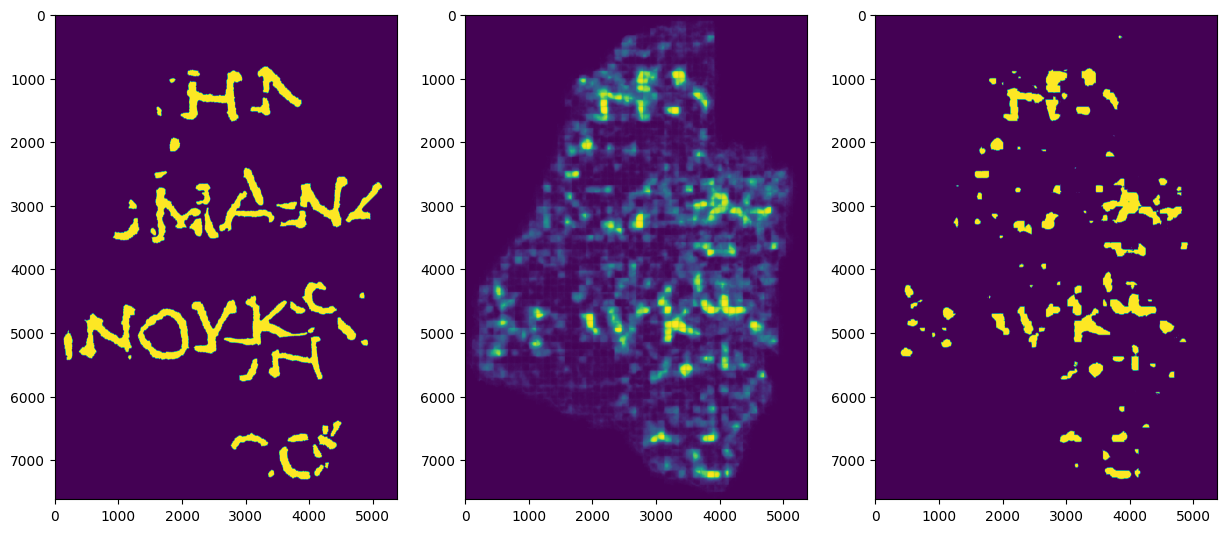

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([24491221.,  4991600.,  3033118.,  2068318.,  1581991.,  1168533.,
          822657.,   502666.,   332147.,   261570.,   217784.,   191573.,
          169566.,   157782.,   155953.,   149812.,   145641.,   153496.,
          159831.,   188357.]),
 array([1.43274283e-04, 5.00982229e-02, 1.00053171e-01, 1.50008120e-01,
        1.99963069e-01, 2.49918017e-01, 2.99872966e-01, 3.49827914e-01,
        3.99782863e-01, 4.49737812e-01, 4.99692760e-01, 5.49647709e-01,
        5.99602657e-01, 6.49557606e-01, 6.99512555e-01, 7.49467503e-01,
        7.99422452e-01, 8.49377400e-01, 8.99332349e-01, 9.49287298e-01,
        9.99242246e-01]),
 <BarContainer object of 20 artists>)

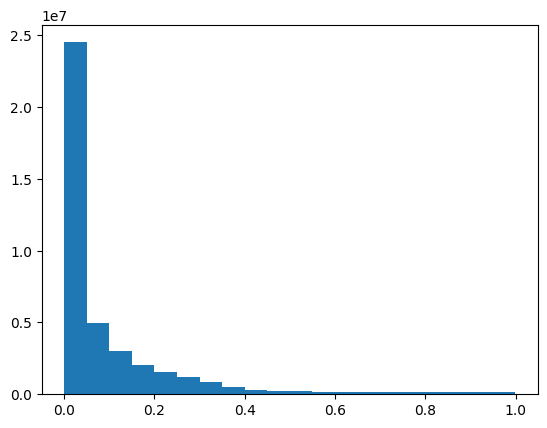

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000